# Sentiment emotions regressor

1. Data pre-processing
2. Feature engineering
3. Model building

In [1]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas as pd
import numpy as np
import emoji
import xgboost, textblob, string, ekphrasis, nltk, re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from xgboost.sklearn import XGBClassifier

from sklearn.svm import NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from mlxtend.classifier import StackingCVClassifier

from ekphrasis.classes.spellcorrect import SpellCorrector
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

import gensim
from gensim.models import Word2Vec

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from gensim.models.doc2vec import TaggedDocument

sp = SpellCorrector(corpus="english") 

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Reading english - 1grams ...


In [2]:
emotion = 'sadness'

train = pd.read_csv('Data/Anger:fear:joy:sadness/Continuous/EI-reg-En-train/EI-reg-En-{}-train.txt'
                    .format(emotion), sep='\t')
valid = pd.read_csv('Data/Anger:fear:joy:sadness/Continuous/2018-EI-reg-En-dev/2018-EI-reg-En-{}-dev.txt'
                    .format(emotion), sep='\t')

tweets = train.append(valid)
tweets = tweets.reset_index(drop = True)
tweets = tweets.drop(['ID', 'Affect Dimension'], axis = 1)

tweets.columns = ['text', 'y']

tweets

,text,y
0,This the most depressing shit ever,0.861
1,final vestiges of my 90's childhood were just ...,0.417
2,@ManUnitedWriter He has had a dreadful first h...,0.500
3,feel really sad and down today😒,0.833
4,Wow just watched Me Before You and it was seri...,0.667
...,...,...
1925,@JeffBezos @amazon Who can I talk to about bei...,0.553
1926,Brown envelopes can induce panic. #posttruth,0.522
1927,I wont rt things that might offend your faves ...,0.400
1928,and after i got home in such a horrible mood m...,0.727


## Data pre-processing

1. Normalization, unpacking, tokenizer
2. Tweet cleaning, lemmatizer, stopword removal

In [3]:
text_processor = TextPreProcessor(
    normalize=['url', 'email', 'percent', 'money', 'phone', 'time', 'date', 'number'],
    fix_html=True,  
    segmenter="twitter", 
    corrector="twitter", 
    unpack_hashtags=True,  
    unpack_contractions=True, 
    spell_correct_elong=True,
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)

/opt/anaconda3/lib/python3.7/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


/opt/anaconda3/lib/python3.7/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


In [4]:
stopwords = nltk.corpus.stopwords.words('english')
rooter = nltk.stem.WordNetLemmatizer().lemmatize
punctuation = '!"$%&\'()*+,-./:;=?[\\]^_`{|}~•'

def get_word_and_tag(tokens):
    tagged = pos_tag(tokens)
    cleaned_tags = []
    for word, tag in tagged:
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        cleaned_tags.append((word,pos))
    return cleaned_tags

def clean_tweet(tweet):
    tweet = tweet.lower() # lower case
    tweet = emoji.demojize(tweet) #emojis to text
    tweet = re.sub('['+punctuation + ']+', ' ', tweet) # remove punctuation
    tokens = [word for word in tweet.split(' ') if word not in stopwords] # remove stopwords
    tokens = [word for word in tokens if len(word)>0] #remove double spaces
    
    tokens = [rooter(word,tag) for word,tag in get_word_and_tag(tokens)] # apply word rooter with POS tagging
    tweet = ' '.join(tokens)
    return tweet

In [5]:
tweets['corrected_text'] = [" ".join(text_processor.pre_process_doc(s)) for s in tweets.text]
tweets['corrected_text'] = tweets['corrected_text'].apply(clean_tweet)

In [6]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(tweets['corrected_text'], 
                                                                      tweets['y'], test_size = 0.2, random_state=0)

## Model building

In [10]:
def train_model(regressor, train, train_y, valid, valid_y):
    """
    regressor: Classifier object
    train: Train predictors
    train_y: Train y
    valid: Validation predictors
    valid_y: Validation y
    """
    regressor.fit(train, train_y)
    preds = regressor.predict(valid)
    return preds

In [11]:
def prep_data(emotion):
    """
    emotion: Emotion data to prepare
    Read and clean the dataset 
    """
    train = pd.read_csv('Data/Anger:fear:joy:sadness/Continuous/EI-reg-En-train/EI-reg-En-{}-train.txt'
                        .format(emotion), sep='\t')
    valid = pd.read_csv('Data/Anger:fear:joy:sadness/Continuous/2018-EI-reg-En-dev/2018-EI-reg-En-{}-dev.txt'
                        .format(emotion), sep='\t')

    tweets = train.append(valid)
    tweets = tweets.reset_index(drop = True)
    tweets = tweets.drop(['ID', 'Affect Dimension'], axis = 1)

    tweets.columns = ['text', 'y']
    
    tweets['corrected_text'] = [" ".join(text_processor.pre_process_doc(s)) for s in tweets.text]
    
    tweets['corrected_text'] = tweets['corrected_text'].apply(clean_tweet)
    
    return tweets

In [17]:
for emotion in ['anger', 'fear', 'joy', 'sadness']:
    print(emotion)
    tweets = prep_data(emotion)
    
    #Train, test split
    train_x, valid_x, train_y, valid_y = model_selection.train_test_split(tweets['corrected_text'], 
                                                                          tweets['y'], test_size = 0.2, random_state=0)
    
    #Create count vectors
    count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{3,}', max_features=5000)
    count_vect.fit(tweets.corrected_text)
    x_count = count_vect.transform(tweets.corrected_text)
    xtrain_count =  count_vect.transform(train_x)
    xvalid_count =  count_vect.transform(valid_x)
    
    #Initialize regressor
    regressor = xgboost.XGBRegressor(n_estimators=1000, max_depth = 2, learning_rate = 0.2)

    preds = train_model(regressor, xtrain_count, train_y, xvalid_count, valid_y)
    print('Correlation coefficient: ', np.corrcoef(preds, valid_y)[1,0])

anger
Correlation coefficient:  0.6336445230648905
fear
Correlation coefficient:  0.6400042465786856
joy
Correlation coefficient:  0.5884656050756636
sadness
Correlation coefficient:  0.6677664443063058


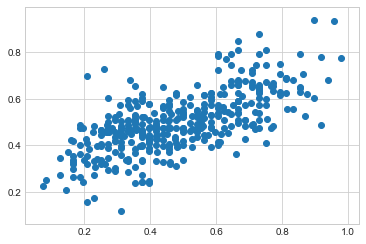

In [13]:
d = {'Actual': valid_y, 'Predictions':preds}

res = pd.DataFrame(d)

plt.scatter(res.Actual, res.Predictions)